In [1]:
from PIL import Image,ImageFilter
from pytesseract import pytesseract
from skimage import io
import matplotlib.pyplot as plt
import torch
import cv2
import easyocr
import os
import numpy as np
from skimage.transform import rescale, resize
import torch.nn as nn
from PIL import Image, ImageDraw, ImageFont,ImageFilter

from skimage.transform import resize

In [2]:
symbol_set = ' .,?:;—!<>-«»()[]*"АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя0123456789'
cnn_out_channels = 128
linear_out_channels = len(symbol_set)
space_code = symbol_set.index(' ')

class MyOCR(nn.Module):
    def __init__(self):
        super(MyOCR, self).__init__()

        self.conv0 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, cnn_out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1, ceil_mode=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1, ceil_mode=False)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,1), stride=None, padding=0, dilation=1, ceil_mode=False)
        
        self.activ = nn.LeakyReLU()
        #self.activ = nn.ReLU()
        self.avgpool = nn.AdaptiveMaxPool2d((1, None))
 
        self.lin1 = nn.Linear(cnn_out_channels , linear_out_channels)
        self.log_softmax = nn.LogSoftmax(dim=2)
        #self.log_softmax = nn.Softmax(dim=2)

        
    def forward(self, x): #[Batch, 1, 32, 360]
                                 
        x = self.conv0(x) #[Batch, 16, 32, 360]
        x = self.pool0(x) #[Batch, 16, 16, 180]
        x = self.activ(x)
        
        x = self.conv1(x) #[Batch, 32, 16, 180]
        x = self.pool1(x) #[Batch, 32, 8, 90]
        x = self.activ(x) 
        
        x = self.conv2(x) #[Batch, 64, 8, 90]
        x = self.pool2(x) #[Batch, 64, 4, 90]
        x = self.activ(x)
        
        x = self.avgpool(x) #[Batch, 64, 1, 90]

        x = x.permute(0, 3, 1, 2).view(x.size(0), x.size(3), -1) # [Batch, 90, 64]
        
        x = self.lin1(x) #[Batch, 90, features]
        x = self.activ(x)
        
        #x = self.dropout(x)
        x = self.log_softmax(x) #[Batch, 90, features_proba]

        return x

In [22]:
# text <-> code functions
def text_to_numbers(text: str) -> np.array:
    return np.array([symbol_set.index(c) for c in text], dtype=np.int64)

def numbers_to_text(arr) -> str:
    return ''.join([symbol_set[code] for code in arr])


# clear and decode sequence of codes to text 
def decode_sequence(seq :np.array)-> str:
    out = []
    space_count = 0
    dl_count = 0      
    current_code = None
    letter_dist = 9
    double_sign = 5

    for _, v in enumerate(seq):
        
        # if a sequence of spaces has length letter_dist or more, 
        #recognize it as a blank space
        # otherwise - ignore
        if v == space_code:
            space_count+=1
            current_code = None
            if space_count == letter_dist:
                space_count = 0
                out.append(space_code)
            continue
        
        # when detecting long enough sequence of the same codes (except blank), 
        # recognize it as two adjecent double letters 
        if v == current_code:            
            dl_count +=1
            if dl_count == double_sign:
                dl_count = 0
                out.append(current_code)
            continue

        current_code = v            
        out.append(v)
                    
    return ''.join(numbers_to_text(out))


def test_decode_sequence(input, expected):
    numbers = text_to_numbers(input)
    result = decode_sequence(numbers)
    print ('result',result) 
    print('expected',expected)
    print( 'is_coinside', result == expected)

    
def decode_batch(input):
    # input in shape: [Batch, seq, features]
    # output: [Batch, seq_text]
    maxed = torch.argmax(input.cpu(), -1).numpy()
    return [decode_sequence(seq) for seq in maxed]


def load_image(path: str) -> torch.tensor:
    img = io.imread(path)
    img = torch.from_numpy(img).view(1, 32, -1).float()
    return img

In [4]:
docs_path = 'DataForOCR/'
docs = os.listdir(docs_path)


In [5]:
reader = easyocr.Reader(['ru'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [6]:
path = './models/best_model1.pth'
model = MyOCR()
model.load_state_dict(torch.load(path))
model.eval()

MyOCR(
  (conv0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (activ): LeakyReLU(negative_slope=0.01)
  (avgpool): AdaptiveMaxPool2d(output_size=(1, None))
  (lin1): Linear(in_features=128, out_features=95, bias=True)
  (log_softmax): LogSoftmax(dim=2)
)

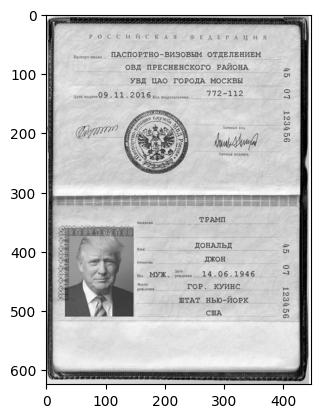

In [17]:
link = docs_path + docs [0]
image = cv2.imread(link,0)
plt.imshow(image, cmap='gray')

In [18]:
result = reader.detect(link, width_ths = 0.4)[0][0]

In [19]:
img_boxes = []

for box in result:
    img_box = image[box[2]:box[3], box[0]:box[1]]
    img_boxes.append(img_box)

In [20]:
def preprocess_img(img):
    w = 360
    h = 32
    h0 = img.shape[0]
    w0 = img.shape[1]
    w1 = int(h/h0*w0)
    img2 = cv2.resize(img,(w1,h))
    img2 = torch.from_numpy(img2).float()

    return img2

def recognize(img,model):
   
    outputs = model (img)
    #outputs = outputs.permute(1,0,2)
    outs_decoded = decode_batch(outputs)
    return simplify(outs_decoded[0])
    #return outs_decoded

def simplify(seq):
    result = ''
    for i in seq:
        if i!= '':
            result+=i
    return result
 

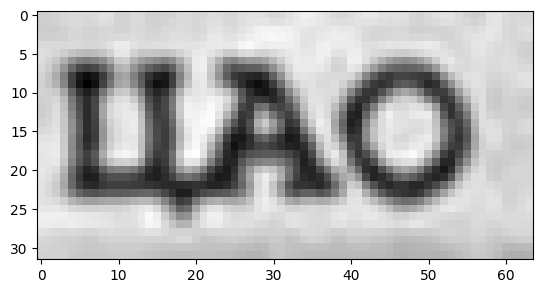

In [28]:
#img0 = io.imread('raw_data/synth_dataset/images/26_pasp.png')
img0 = img_boxes [8]
img1 = preprocess_img(img0)
plt.imshow(img1, cmap='gray')
plt.show()

img1 = img1.view(1,1, 32, -1)
text = recognize(img1,model)
print(text)

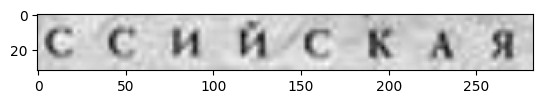

predicted :        А Я


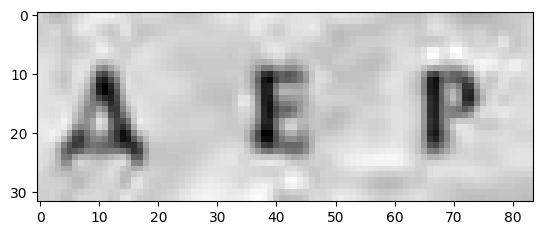

predicted :  ДАЕ  


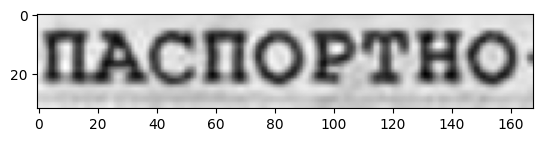

predicted :    С  С


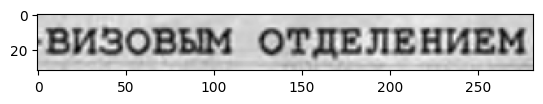

predicted :  ВТ  В Д   Е 


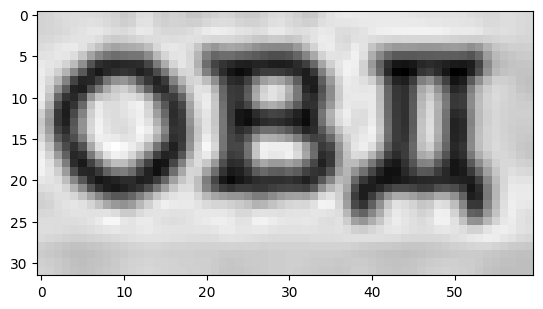

predicted :   


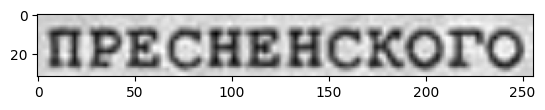

predicted :   Е    Т 


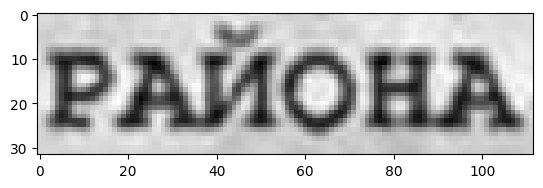

predicted :  0 Й В


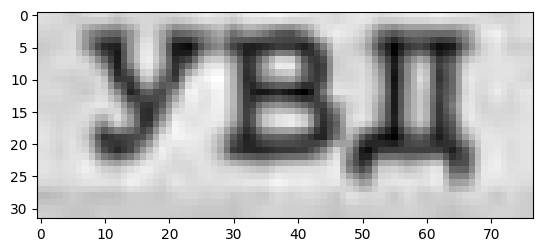

predicted :    


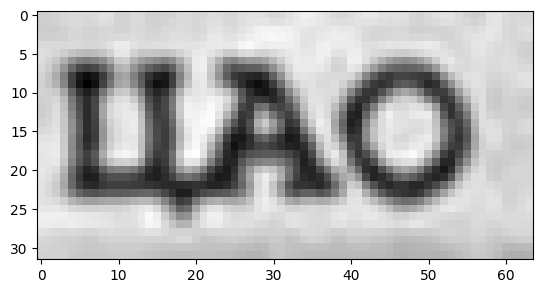

predicted :   


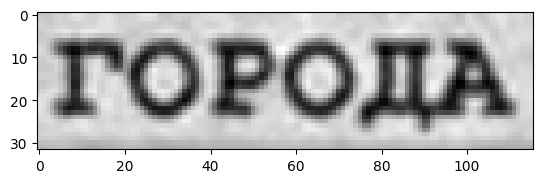

predicted :    Д 


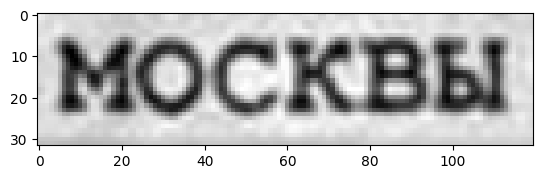

predicted :     


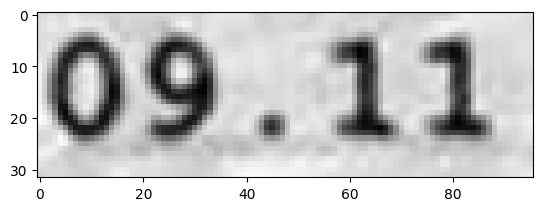

predicted :    


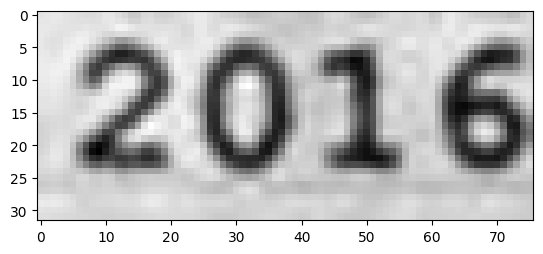

predicted :  2 С


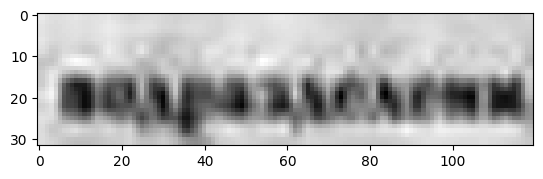

predicted :     


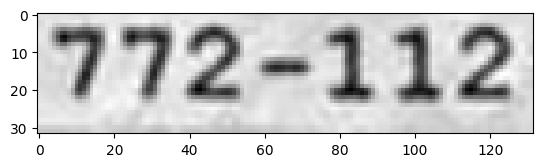

predicted :     


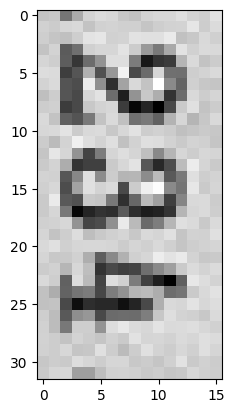

predicted :  


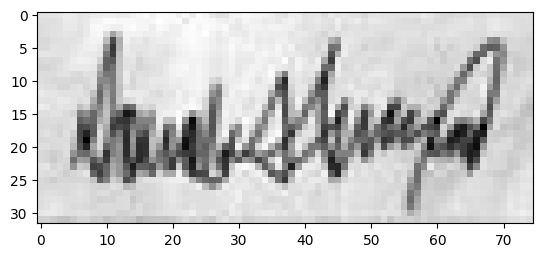

predicted :  З АЙ


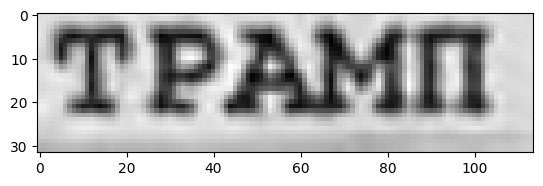

predicted :     


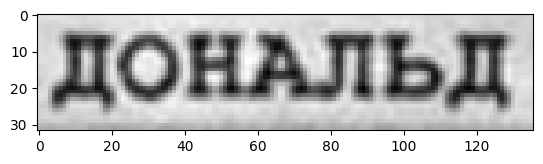

predicted :  ДС  СЙ 


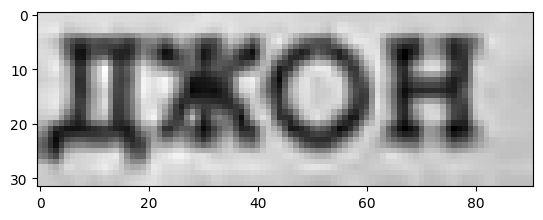

predicted :  О  


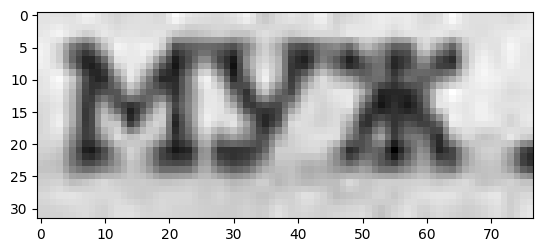

predicted :    


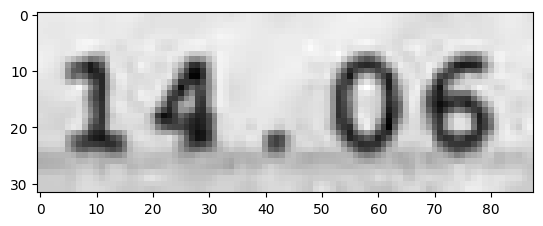

predicted :  ТАФ,  


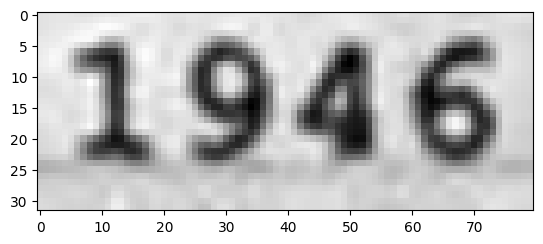

predicted :    


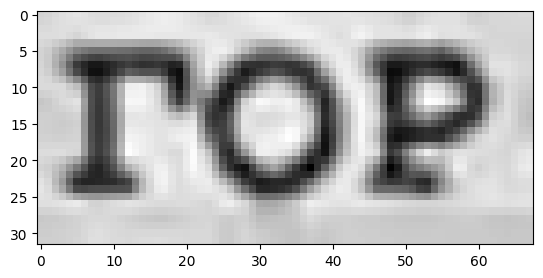

predicted :  ТС 


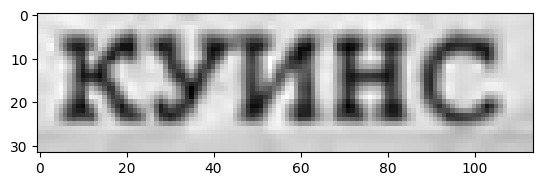

predicted :     


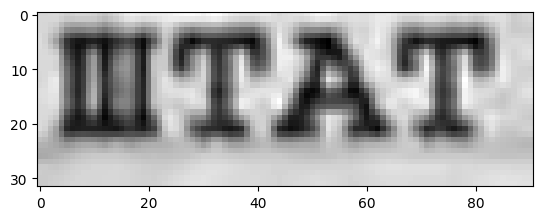

predicted :    


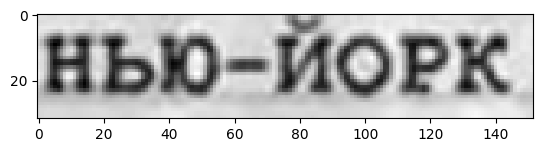

predicted :  Е ЮЙ О 


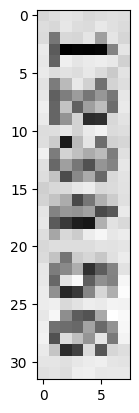

predicted :  


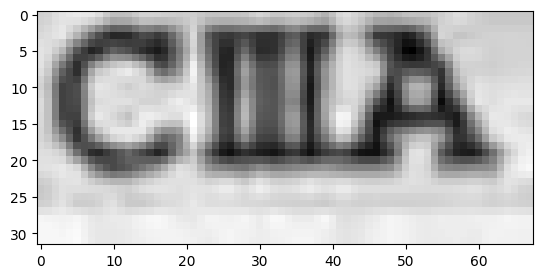

predicted :   


In [31]:
for im in img_boxes:
    im = preprocess_img(im)
    plt.imshow(im, cmap='gray')
    plt.show()
    im = im.view(1, 1, 32, -1)
    text = recognize(im,model)
    print('predicted : ', text)